In [102]:
# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "/root/assignment1"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/root/{}'.format(FOLDERNAME))

In [103]:
sys.path

['/root/assignment1',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/root//root/assignment1',
 '/root//root/assignment1',
 '/root//root/assignment1',
 '/root//root/assignment1',
 '/root//root/assignment1']

In [104]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /root/assignment1/cs231n/datasets/

/root/assignment1/cs231n/datasets


In [105]:
!bash get_datasets.sh

In [106]:
%cd /root/assignment1/

/root/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [107]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [108]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


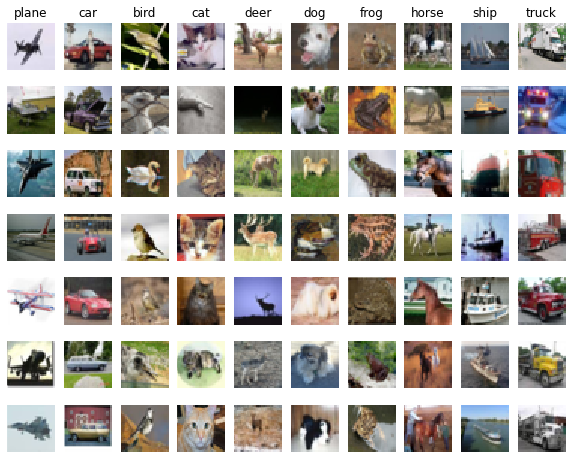

In [109]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [110]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)  # range(49000, 50000)
X_val = X_train[mask] # X_val[range(49000, 50000)] / (1000, 32, 32, 3)
y_val = y_train[mask] # y_val[range(49000, 50000)] / (1000,)

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training) # range(49000)
X_train = X_train[mask] # X_train[range(49000)] / (49000, 32, 32, 3)
y_train = y_train[mask] # y_train[range(49000)] / (49000,)

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False) # (49000, 500)
X_dev = X_train[mask] # (500, 32, 32, 3)
y_dev = y_train[mask] # (500,)

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test) # range(1000)
X_test = X_test[mask] # X_test(range(1000)) / (1000, 32, 32, 3)
y_test = y_test[mask] # y_test(range(1000)) / (1000,)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [111]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # -1 → 32*32*3 = 3072
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


mean_image:  [130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


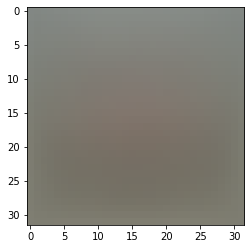

X_train.shape: (49000, 3073), X_val.shape: (1000, 3073), X_test.shape: (1000, 3073), X_dev.shape: (500, 3073)


In [112]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print("mean_image: ", mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print("X_train.shape: {}, X_val.shape: {}, X_test.shape: {}, X_dev.shape: {}".format(X_train.shape, X_val.shape, X_test.shape, X_dev.shape))

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [113]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.083554


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [114]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0) # svm_loss_naive(W:weights, X:a minibatch of data, y:training labels, reg:reguralization strength)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -6.393042 analytic: -6.393042, relative error: 3.883168e-11
numerical: 7.958361 analytic: 7.958361, relative error: 1.129854e-11
numerical: -3.857562 analytic: -3.857562, relative error: 4.148544e-11
numerical: 22.623388 analytic: 22.623388, relative error: 1.455672e-11
numerical: 25.615210 analytic: 25.615210, relative error: 9.404247e-13
numerical: 8.926621 analytic: 8.926621, relative error: 6.076704e-11
numerical: -4.952184 analytic: -4.952184, relative error: 3.735260e-11
numerical: 40.441849 analytic: 40.441849, relative error: 1.888193e-12
numerical: -20.902532 analytic: -20.902532, relative error: 5.843081e-12
numerical: -9.523380 analytic: -9.523380, relative error: 8.052807e-11
numerical: 4.273903 analytic: 4.273903, relative error: 9.532207e-11
numerical: -52.830312 analytic: -52.830312, relative error: 1.198555e-12
numerical: -3.549429 analytic: -3.549429, relative error: 2.713065e-11
numerical: 22.025671 analytic: 22.025671, relative error: 9.946408e-12
numerica

**Inline Question 1**

- It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern?  (가끔 gradcheck의 차원이 불일치 할 수 있다. 그렇다면 원인은 무엇이고 걱정할만한 것인지?)
- What is a simple example in one dimension where a gradient check could fail?  How would change the margin affect of the frequency of this happening? (1차원일 때 gradcheck가 다를 경우의 예시 그리고 이런 경우의 빈도를 영향을 어떻게 변경할 수 있는지?)
- *Hint: the SVM loss function is not strictly speaking differentiable* (SVM loss 함수는 엄밀히 말하면 미분불가능임)

$\color{Red}{\textit Your Answer:}$ 

- 불일치하는 원인: *미분 불가능한 점에서 불일치가 발생한다.*
- 이유: *svm loss의 경우, 불일치하는 지점은 x=0일 때이고 이때 수치적, 해석적 미분 식이 달라져서 값이 차이가 발생함*  
- 걱정: *근소한 차이지만 매개변수 업데이트에 영향을 줄 수 있지만 큰 문제는 아니다.*
- 예시: *x=1e-8일 때, max(0,x)이면 analytic은 0이고, numerical의 경우, 0.9가 나옴. 따라서 기울기를 계산할 때 차이가 발생한다.*
- 빈도 줄이는 법: *gradient를 계산할 때, 오차를 줄이는 방법과 동일하다고 생각.*

In [115]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.083554e+00 computed in 0.059394s
Vectorized loss: 9.083554e+00 computed in 0.002531s
difference: -0.000000


In [116]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.066581s
Vectorized loss and gradient: computed in 0.001759s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [117]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.067743
iteration 100 / 1500: loss 287.487856
iteration 200 / 1500: loss 108.248204
iteration 300 / 1500: loss 42.534025
iteration 400 / 1500: loss 18.669682
iteration 500 / 1500: loss 10.604340
iteration 600 / 1500: loss 7.277708
iteration 700 / 1500: loss 6.316416
iteration 800 / 1500: loss 4.952629
iteration 900 / 1500: loss 5.333736
iteration 1000 / 1500: loss 5.418450
iteration 1100 / 1500: loss 5.468070
iteration 1200 / 1500: loss 5.401137
iteration 1300 / 1500: loss 5.681885
iteration 1400 / 1500: loss 5.310071
That took 4.060779s


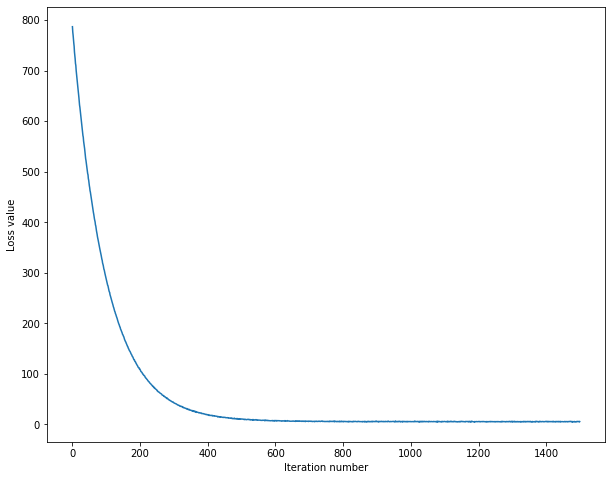

In [118]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [119]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370245
validation accuracy: 0.390000


In [120]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [121]:
import warnings
warnings.filterwarnings("ignore")

##### RuntimeWarning 발생 이유:
- 코드가 “0으로 나누기”또는 “NaN으로 나누기”를 시도하고 있다고 생각하기 때문에 일부러 오류를 발생. 업데이트 되는 값이 0에 가까운 작은 값을 산출하기 때문에
- 잘못 계산되고 있는 것은 아니라고 판단
- 따라서 *import warinings*를 통해 에러 출력을 없애주었음
- 참고: [RuntimeWarning](http://daplus.net/python-runtimewarning-%EB%82%98%EB%88%84%EA%B8%B0%EC%97%90%EC%84%9C-%EC%9E%98%EB%AA%BB%EB%90%9C-%EA%B0%92%EC%9D%B4-%EB%B0%9C%EA%B2%AC%EB%90%98%EC%97%88%EC%8A%B5%EB%8B%88%EB%8B%A4/)

In [123]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6, 2e-6, 2e-7, 3e-6, 3e-7]
# learning_rates = np.linspace(1e-7, 3e-7, 5)
regularization_strengths = [2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4, 6e4]
# regularization_strengths = np.linspace(2.e4, 6e4, 10)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=3000, 
                  verbose=False)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[lr, rs] = [train_acc, val_acc]
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.369102 val accuracy: 0.380000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.365408 val accuracy: 0.382000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.366184 val accuracy: 0.372000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.358388 val accuracy: 0.376000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.358633 val accuracy: 0.371000
lr 1.000000e-07 reg 4.500000e+04 train accuracy: 0.350408 val accuracy: 0.365000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.359286 val accuracy: 0.361000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 0.352857 val accuracy: 0.363000
lr 2.000000e-07 reg 2.000000e+04 train accuracy: 0.358714 val accuracy: 0.359000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.357837 val accuracy: 0.378000
lr 2.000000e-07 reg 3.000000e+04 train accuracy: 0.362122 val accuracy: 0.369000
lr 2.000000e-07 reg 3.500000e+04 train accuracy: 0.361633 val accuracy: 0.356000
lr 2.000000e-07 reg 4.000000

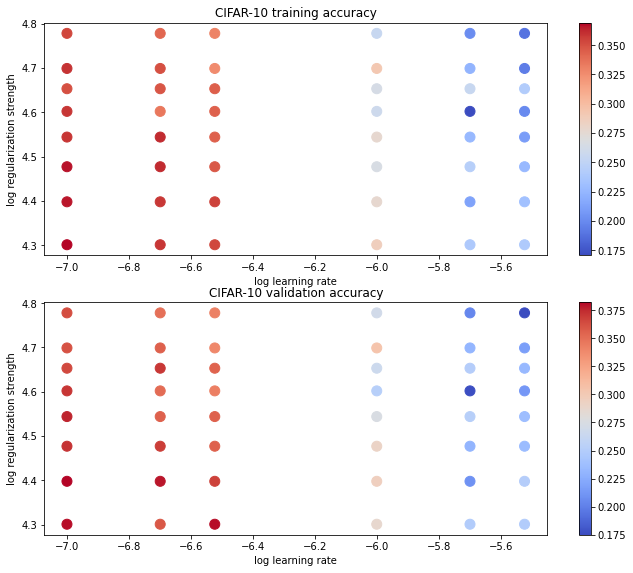

In [124]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [125]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.364000


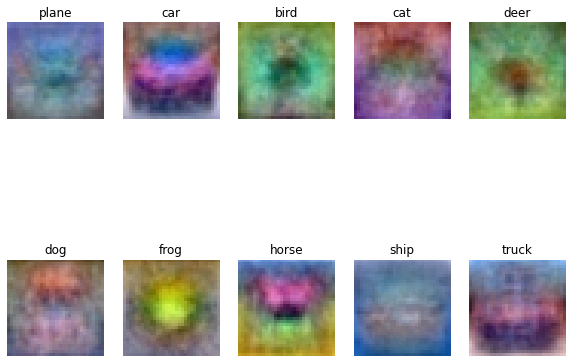

In [126]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do. (SVM 가중치가 어떻게 생겼는지와 왜 저렇게 보이는지에 대해 설명)

$\color{Red}{\textit Your Answer:}$ 

- *각 class 이미지들의 평균이라 볼 수 있음. 즉, image feature들의 일반화된 모습.*
- *각 class가 갖고 있는 고유한 feature를 학습했기 때문. 흐릿해서 잘 안 보이지만, 색깔이나 모양의 특징을 뽑아 학습함*
- *SVM은 linear classifier라서 한계가 존재. 정확한 decision boundary를 생성할 수 없음. 시각화한 가중치를 보면 대칭된다는 특징이 있음. 이는 weights가 중요한 feature만 추출하려고 하기 때문*
- *결국 svm classfier는 tempelete matching이며, 가중치는 데이터에서 학습된 각 클래스에 대한 이미지 템플릿입니다. class를 예측하기 위해 테스트 이미지를 모든 훈련 예제와 비교해야 했던 KNN과 달리, SVM은 L1 또는 L2 대신 내적을 사용하여 test 이미지와 템플릿을 비교합니다.*
